In [1]:
import pandas as pd
import numpy as np
import json
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# print current working directory
import os
print(os.getcwd())

# print all files in current directory
print(os.listdir())

# print all files in raw_data folder
print(os.listdir("../../raw_data"))

# print all files in data_scripts folder

w:\04-Competition Files\TIC 8\Project Repo\Backend\data_scripts
['add_population_poverty.ipynb', 'full_geocoded_health_centers.csv', 'geocoded_health_centers.csv', 'health_facility_preprocess.ipynb', 'logs', 'puskesmas_data_toup.csv', 'regency_csv', 'regency_list.json', 'scrape_bps.py', 'update_subdistricts_population_poverty.sql']
['1732157570673ea0828311d8.00594061.pdf', 'Daftar_Nama_Puskesmas_di_Propinsi_Jawa_Barat.pdf', 'Daftar_Nama_Puskesmas_di_Propinsi_Jawa_Barat.xlsx', 'Daftar_Nama_Puskesmas_di_Propinsi_Jawa_Barat_Fixed.xlsx', 'Data Populasi Penduduk Kecamatan', 'idn_general_2020_csv', 'idn_general_2020_csv.zip', 'idn_ppp_2020_constrained.tif', 'Penduduk Miskin Kab Kota Filtered.xlsx', 'Persentase Penduduk Miskin (P0) Menurut Kabupaten_Kota, 2023.csv', 'RBI10K_ADMINISTRASI_DESA_20230928.gdb', 'RBI10K_ADMINISTRASI_DESA_20230928.gdb.zip', 'RBI50K_ADMINISTRASI_KABKOTA_20230907.gdb', 'RBI50K_ADMINISTRASI_KABKOTA_20230907.gdb.zip', '~$Daftar_Nama_Puskesmas_di_Propinsi_Jawa_Barat_Fixe

In [3]:
raw_data_folder = "../../raw_data"
poverty_data = pd.read_excel(f"{raw_data_folder}/Penduduk Miskin Kab Kota Filtered.xlsx")

In [4]:
poverty_data

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi
0,Adm. Kep. Seribu,13.13,DKI JAKARTA
1,Kota Jakarta Selatan,3.10,DKI JAKARTA
2,Kota Jakarta Timur,4.20,DKI JAKARTA
3,Kota Jakarta Pusat,4.68,DKI JAKARTA
4,Kota Jakarta Barat,4.09,DKI JAKARTA
...,...,...,...
135,Halmahera Timur,12.47,MALUKU UTARA
136,Pulau Morotai,5.38,MALUKU UTARA
137,Pulau Taliabu,7.31,MALUKU UTARA
138,Kota Ternate,3.39,MALUKU UTARA


In [5]:
poverty_data.loc[poverty_data["Kota_Kabupaten"] == "Gunung Kidul"]

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi
70,Gunung Kidul,15.6,DI YOGYAKARTA


In [6]:
# replace Gunung Kidul with Gunungkidul to match the population_data
poverty_data = poverty_data.replace("Gunung Kidul", "Gunungkidul")

In [7]:
# replace kota_kabupaten that contains "Kota Jakarta XXX" with "Kota Adm. Jakarta XXX" to match the population_data
poverty_data["Kota_Kabupaten"] = poverty_data["Kota_Kabupaten"].str.replace(
    r"^Kota Jakarta", "Kota Adm. Jakarta", regex=True
)

In [8]:
poverty_data.loc[poverty_data["Kota_Kabupaten"].str.contains("Jakarta")]

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi
1,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA
2,Kota Adm. Jakarta Timur,4.20,DKI JAKARTA
3,Kota Adm. Jakarta Pusat,4.68,DKI JAKARTA
4,Kota Adm. Jakarta Barat,4.09,DKI JAKARTA
5,Kota Adm. Jakarta Utara,6.78,DKI JAKARTA


In [9]:
poverty_data.loc[poverty_data["Kota_Kabupaten"] == "Gunungkidul"]

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi
70,Gunungkidul,15.6,DI YOGYAKARTA


In [10]:
population_data = pd.read_excel(f"{raw_data_folder}/Data Populasi Penduduk Kecamatan/1-JavaMaluku_SubdistrictsPopulation.xlsx")

In [11]:
population_data.loc[population_data['Kota_Kabupaten'] == 'Gunungkidul']

,Kecamatan,Jumlah Penduduk,Kota_Kabupaten,Tahun
632,Panggang,28990.0,Gunungkidul,2023
633,Purwosari,20543.0,Gunungkidul,2023
634,Paliyan,32135.0,Gunungkidul,2023
635,Saptosari,38639.0,Gunungkidul,2023
636,Tepus,35423.0,Gunungkidul,2023
637,Tanjungsari,28249.0,Gunungkidul,2023
638,Rongkop,28429.0,Gunungkidul,2023
639,Girisubo,24598.0,Gunungkidul,2023
640,Semanu,58722.0,Gunungkidul,2023
641,Ponjong,54588.0,Gunungkidul,2023


In [12]:
# Join poverty_data with population_data on Kota_Kabupaten names
pop_pov_data = poverty_data.merge(population_data, left_on="Kota_Kabupaten", right_on="Kota_Kabupaten", how="left")

In [13]:
pop_pov_data

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi,Kecamatan,Jumlah Penduduk,Tahun
0,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Selatan,11948.0,2023.0
1,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Utara,16575.0,2023.0
2,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Jagakarsa,383420.0,2023.0
3,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Pasar Minggu,335480.0,2023.0
4,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Cilandak,229740.0,2023.0
...,...,...,...,...,...,...
2682,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Tidore Timur,9772.0,2023.0
2683,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba,14349.0,2023.0
2684,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Selatan,6914.0,2023.0
2685,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Utara,21210.0,2023.0


In [14]:
pop_pov_data.isnull().sum()

Kota_Kabupaten            0
Tingkat_Kemiskinan (%)    0
Provinsi                  0
Kecamatan                 1
Jumlah Penduduk           1
Tahun                     1
dtype: int64

In [15]:
# show rows where kecamatan is null
pop_pov_data[pop_pov_data["Kecamatan"].isnull()]

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi,Kecamatan,Jumlah Penduduk,Tahun
2454,Maluku Tenggara Barat,24.47,MALUKU,NaN,NaN,NaN


In [16]:
# show rows where Kota_Kabupaten contains "tasikmalaya"
population_data.loc[population_data["Kota_Kabupaten"].str.contains("Pekalongan")]

,Kecamatan,Jumlah Penduduk,Kota_Kabupaten,Tahun
1420,Pekalongan Barat,97191.0,Kota Pekalongan,2023
1421,Pekalongan Timur,70226.0,Kota Pekalongan,2023
1422,Pekalongan Selatan,69810.0,Kota Pekalongan,2023
1423,Pekalongan Utara,80297.0,Kota Pekalongan,2023
2654,Kandangserang,36190.0,Pekalongan,2023
2655,Paninggaran,43054.0,Pekalongan,2023
2656,Lebakbarang,11256.0,Pekalongan,2023
2657,Petungkriyono,13309.0,Pekalongan,2023
2658,Talun,31480.0,Pekalongan,2023
2659,Doro,46499.0,Pekalongan,2023


In [17]:
province_regency_metadata = pd.read_csv(f"{raw_data_folder}/Data Populasi Penduduk Kecamatan/id-name-province metadata.csv")

In [18]:
province_regency_metadata

,id,name,province_id
0,170b60da-4b4c-4db3-87be-cc789a184665,Sleman,12bba251-7eb0-4157-a6e1-0bfdbf0e0595
1,2395ef58-bbd8-4eb0-8db5-7ebd1fa2eed4,Gunungkidul,12bba251-7eb0-4157-a6e1-0bfdbf0e0595
2,05d61d64-371e-4e63-a445-e055188cba0f,Bantul,12bba251-7eb0-4157-a6e1-0bfdbf0e0595
3,3fae50ef-5166-4647-a405-2d3d92bd0d03,Kota Yogyakarta,12bba251-7eb0-4157-a6e1-0bfdbf0e0595
4,f175c9ec-3eb0-47a7-a9b3-987db1247eef,Kulon Progo,12bba251-7eb0-4157-a6e1-0bfdbf0e0595
...,...,...,...
136,1dac790a-6123-41a7-95ff-e9e4327a476c,Tuban,c5ae2ebc-fe59-4f67-af7f-4de32456effb
137,716e18fa-a936-479a-933c-6a4960303830,Lamongan,c5ae2ebc-fe59-4f67-af7f-4de32456effb
138,5fc685a9-2c2f-4a12-ad23-315be8055f97,Sumenep,c5ae2ebc-fe59-4f67-af7f-4de32456effb
139,f85007eb-6838-4d49-bbd8-763a618f7244,Gresik,c5ae2ebc-fe59-4f67-af7f-4de32456effb


In [19]:
# add id column from province_regency_metadata to pop_pov_data based on Kota_Kabupaten
fin_pop_pov_data = pop_pov_data.merge(province_regency_metadata, left_on="Kota_Kabupaten", right_on="name", how="left")

In [20]:
fin_pop_pov_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687 entries, 0 to 2686
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Kota_Kabupaten          2687 non-null   object 
 1   Tingkat_Kemiskinan (%)  2687 non-null   float64
 2   Provinsi                2687 non-null   object 
 3   Kecamatan               2686 non-null   object 
 4   Jumlah Penduduk         2686 non-null   float64
 5   Tahun                   2686 non-null   float64
 6   id                      2686 non-null   object 
 7   name                    2686 non-null   object 
 8   province_id             2686 non-null   object 
dtypes: float64(3), object(6)
memory usage: 189.1+ KB


In [21]:
fin_pop_pov_data

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi,Kecamatan,Jumlah Penduduk,Tahun,id,name,province_id
0,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Selatan,11948.0,2023.0,9e083ce7-1d2b-4c8f-b5b2-efdac844ddd3,Adm. Kep. Seribu,84c2bef1-ad7e-4c37-ba89-cde5043dc150
1,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Utara,16575.0,2023.0,9e083ce7-1d2b-4c8f-b5b2-efdac844ddd3,Adm. Kep. Seribu,84c2bef1-ad7e-4c37-ba89-cde5043dc150
2,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Jagakarsa,383420.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
3,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Pasar Minggu,335480.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
4,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Cilandak,229740.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
...,...,...,...,...,...,...,...,...,...
2682,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Tidore Timur,9772.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2683,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba,14349.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2684,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Selatan,6914.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2685,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Utara,21210.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619


In [22]:
fin_pop_pov_data[fin_pop_pov_data["name"].isnull()]

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi,Kecamatan,Jumlah Penduduk,Tahun,id,name,province_id
2454,Maluku Tenggara Barat,24.47,MALUKU,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
fin_pop_pov_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2687 entries, 0 to 2686
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Kota_Kabupaten          2687 non-null   object 
 1   Tingkat_Kemiskinan (%)  2687 non-null   float64
 2   Provinsi                2687 non-null   object 
 3   Kecamatan               2686 non-null   object 
 4   Jumlah Penduduk         2686 non-null   float64
 5   Tahun                   2686 non-null   float64
 6   id                      2686 non-null   object 
 7   name                    2686 non-null   object 
 8   province_id             2686 non-null   object 
dtypes: float64(3), object(6)
memory usage: 189.1+ KB


In [24]:
fin_pop_pov_data.dropna(inplace=True)

In [25]:
fin_pop_pov_data.where(pd.notnull(fin_pop_pov_data), None)

,Kota_Kabupaten,Tingkat_Kemiskinan (%),Provinsi,Kecamatan,Jumlah Penduduk,Tahun,id,name,province_id
0,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Selatan,11948.0,2023.0,9e083ce7-1d2b-4c8f-b5b2-efdac844ddd3,Adm. Kep. Seribu,84c2bef1-ad7e-4c37-ba89-cde5043dc150
1,Adm. Kep. Seribu,13.13,DKI JAKARTA,Kepulauan Seribu Utara,16575.0,2023.0,9e083ce7-1d2b-4c8f-b5b2-efdac844ddd3,Adm. Kep. Seribu,84c2bef1-ad7e-4c37-ba89-cde5043dc150
2,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Jagakarsa,383420.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
3,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Pasar Minggu,335480.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
4,Kota Adm. Jakarta Selatan,3.10,DKI JAKARTA,Cilandak,229740.0,2023.0,218c5e2c-8fb8-4af1-861a-115a7b424422,Kota Adm. Jakarta Selatan,84c2bef1-ad7e-4c37-ba89-cde5043dc150
...,...,...,...,...,...,...,...,...,...
2682,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Tidore Timur,9772.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2683,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba,14349.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2684,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Selatan,6914.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619
2685,Kota Tidore Kepulauan,6.35,MALUKU UTARA,Oba Utara,21210.0,2023.0,e7feefca-4333-4ead-ab2f-46df8f70ca6a,Kota Tidore Kepulauan,46e9b3b7-fc56-48b9-bfd3-19e3e8cab619


In [26]:
sql_df = fin_pop_pov_data.rename(columns={
    "id": "regency_id",
    "Jumlah Penduduk": "population_count",
    "Tingkat_Kemiskinan (%)": "poverty_level"
}).assign(name=lambda df: df["Kecamatan"].astype(str))[["name", "regency_id", "population_count", "poverty_level"]]

sql_df = fin_pop_pov_data.rename(columns={
    "id": "regency_id",
    "Jumlah Penduduk": "population_count",
    "Tingkat_Kemiskinan (%)": "poverty_level"
}).assign(name=lambda df: df["Kecamatan"].astype(str))[["name", "regency_id", "population_count", "poverty_level"]]

# Fill NaN with NULL for SQL compatibility
sql_df = sql_df.where(pd.notnull(sql_df), None)

# Write SQL update statements to a file (assuming subdistricts already exist and we update by name+regency_id)
with open("update_subdistricts_population_poverty.sql", "w", encoding="utf-8") as f:
    for _, row in sql_df.iterrows():
        name = row["name"]
        regency_id = row["regency_id"]
        population_count = row["population_count"]
        poverty_level = row["poverty_level"]
        set_clauses = []
        if population_count is not None:
            set_clauses.append(f"population_count = {int(population_count)}")
        else:
            set_clauses.append("population_count = NULL")
        if poverty_level is not None:
            set_clauses.append(f"poverty_level = {float(poverty_level)}")
        else:
            set_clauses.append("poverty_level = NULL")
        # Escape single quotes in name for SQL
        name_sql = f"'{str(name).replace('\'', '\'\'')}'" if name is not None else "NULL"
        regency_id_sql = f"'{str(regency_id)}'" if regency_id is not None else "NULL"
        sql = (
            f"UPDATE subdistricts "
            f"SET {', '.join(set_clauses)} "
            f"WHERE name = {name_sql} AND regency_id = {regency_id_sql};"
        )
        f.write(sql + "\n")

In [27]:
population_points = pd.read_csv(f"{raw_data_folder}/idn_general_2020_csv/idn_general_2020.csv")

In [28]:
population_points

,longitude,latitude,idn_general_2020
0,99.671250,7.000139,2.447083
1,99.724861,7.000139,2.447083
2,99.725139,7.000139,2.447083
3,99.757917,7.000139,2.447083
4,99.847917,7.000139,3.024791
...,...,...,...
53958283,122.850972,-10.985417,3.596974
53958284,122.850417,-10.985694,3.596974
53958285,122.850972,-10.985694,3.596974
53958286,122.851250,-10.985694,3.596974


In [29]:
# get first row latitude from population_points
population_points.iloc[-1]["latitude"]

np.float64(-10.985972222288437)

In [30]:
specific_latitude_df = population_points.loc[population_points["latitude"] == np.float64(7.000138888837142)].sort_values('longitude')

# Calculate the differences in longitude between consecutive rows
longitude_diffs = specific_latitude_df['longitude'].diff().abs().dropna()

# Get the minimum and maximum differences
min_diff = longitude_diffs.min()
max_diff = longitude_diffs.max()
avg_diff = longitude_diffs.mean()
median_diff = longitude_diffs.median()

average_kilometers = 110.5 * avg_diff
median_kilometers = 110.5 * median_diff

print(min_diff)
print(max_diff)
print(avg_diff)
print(median_diff)
print(average_kilometers)
print(median_kilometers)

0.0002777777777538404
16.049444444457336
0.046919503129928174
0.00027777777779647295
5.184605095857063
0.03069444444651026


The population_points data points come from a high-resolution grid. The precision is determined not just by the number of decimal places but by the actual spacing between the points.

Data Spacing: The median difference between two of the longitude points in the same latitude is 0.0002778 degrees.

Real-World Distance: The physical distance of one degree of longitude changes with latitude. At latitude of ~7°, one degree of longitude is about 110.5 kilometers.

The calculation is:
110,500 meters * 0.0002778 degrees ≈ 30 meters

So, each point in the dataset represents a population estimate for a grid cell that is roughly 30x30 meters in size.

In [31]:
# simplify the population_points, because currently its very large and takes a lot of time to process
# take every 50th point
population_points_simplified = population_points.iloc[::100]
population_points_simplified

,longitude,latitude,idn_general_2020
0,99.671250,7.000139,2.447083
100,100.425417,7.000139,4.875674
200,100.472083,7.000139,4.875674
300,100.520972,7.000139,4.875674
400,124.565139,7.000139,13.711924
...,...,...,...
53957800,122.934583,-10.919306,3.596974
53957900,122.966250,-10.920972,3.596974
53958000,122.827083,-10.923472,3.596974
53958100,122.853194,-10.927083,3.596974


In [32]:
specific_latitude_df = population_points_simplified.loc[population_points_simplified["latitude"] == np.float64(7.000138888837142)].sort_values('longitude')

# Calculate the differences in longitude between consecutive rows
longitude_diffs = specific_latitude_df['longitude'].diff().abs().dropna()

# Get the minimum and maximum differences
min_diff = longitude_diffs.min()
max_diff = longitude_diffs.max()
avg_diff = longitude_diffs.mean()
median_diff = longitude_diffs.median()

average_kilometers = 110.5 * avg_diff
median_kilometers = 110.5 * median_diff

print(min_diff)
print(max_diff)
print(avg_diff)
print(median_diff)
print(average_kilometers)
print(median_kilometers)

0.04666666666670949
24.04416666668601
5.0830000000040885
0.5211111111115372
561.6715000004518
57.58277777782486


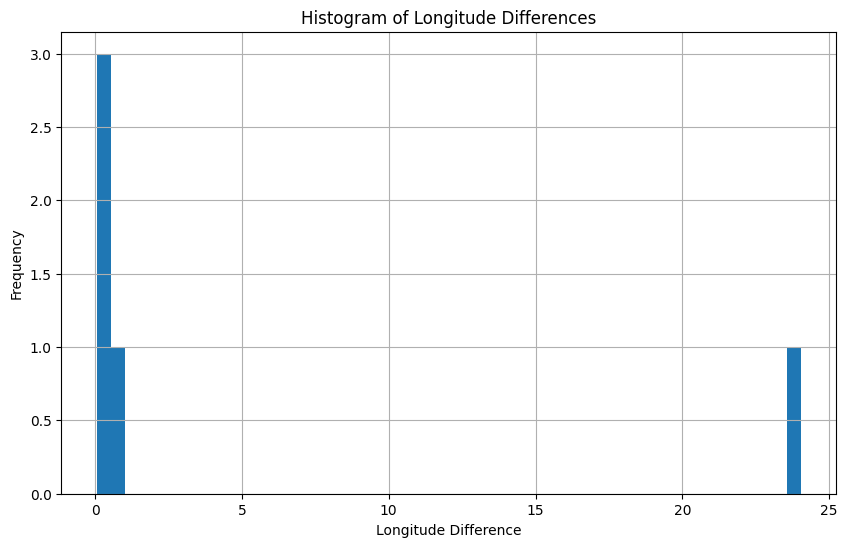

In [33]:
# histogram of the longitude_diffs
longitude_diffs.hist(bins=50, figsize=(10, 6))
plt.title('Histogram of Longitude Differences')
plt.xlabel('Longitude Difference')
plt.ylabel('Frequency')
plt.show()



In [34]:
# Optimized geocoding with chunking, vector operations, and parallel processing
import multiprocessing as mp
from functools import partial
import warnings
warnings.filterwarnings('ignore')

def create_points_chunk(chunk_data):
    """Create Point geometries for a chunk of data using vectorized operations"""
    # Vectorized Point creation - much faster than apply
    points = [Point(lon, lat) for lon, lat in zip(chunk_data['longitude'], chunk_data['latitude'])]
    return gpd.GeoDataFrame(chunk_data, geometry=points)

def process_chunk_parallel(chunk_data, chunk_id):
    """Process a single chunk with parallel processing"""
    try:
        return create_points_chunk(chunk_data)
    except Exception as e:
        print(f"Error processing chunk {chunk_id}: {e}")
        return None

def optimize_geocoding(df, chunk_size=10000, n_jobs=None):
    """
    Optimized geocoding with chunking and parallel processing
    
    Parameters:
    - df: DataFrame with 'longitude' and 'latitude' columns
    - chunk_size: Size of each chunk for processing
    - n_jobs: Number of parallel jobs (None for all available cores)
    """
    if n_jobs is None:
        n_jobs = mp.cpu_count() // 2
    
    print(f"Processing {len(df)} points in chunks of {chunk_size} using {n_jobs} parallel processes...")
    
    # Split data into chunks
    chunks = [df.iloc[i:i+chunk_size] for i in range(0, len(df), chunk_size)]
    print(f"Created {len(chunks)} chunks")
    
    # Process chunks in parallel
    with mp.Pool(processes=n_jobs) as pool:
        # Create partial function with chunk_id for error tracking
        process_func = partial(process_chunk_parallel, chunk_id=0)
        
        # Map chunks to parallel processes
        results = pool.map(process_func, chunks)
    
    # Combine results
    valid_results = [result for result in results if result is not None]
    
    if not valid_results:
        raise ValueError("No valid results from parallel processing")
    
    # Concatenate all GeoDataFrames
    final_gdf = pd.concat(valid_results, ignore_index=True)
    
    print(f"Successfully processed {len(final_gdf)} points")
    return final_gdf

In [35]:
# Use the optimized geocoding function
# encoded_points = optimize_geocoding(population_points_simplified, chunk_size=population_points_simplified.shape[0]//100)
# encoded_points

In [36]:
population_points_simplified.to_csv("population_points_simplified.csv", index=False)